# Clustering-Based Financial Strategies: Pair Trading and Portfolio Optimization

### Objectives:

    1. Leverages clustering techniques to enhance pair trading and portfolio optimization.
    2. Clusters assets with similar characteristics using historical price data.
    3. Selects highly correlated pairs for trading and ensures diversified asset selection.
    4. Applies Markowitz Mean-Variance Optimization framework to determine optimal asset weights.
    5. Monitors trading performance, and assesses portfolio returns.

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline 
import seaborn as sns 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation, DBSCAN
import yfinance as yf 
from sklearn.neighbors import NearestNeighbors
from statsmodels.tsa.stattools import coint  
from sklearn.manifold import TSNE
import matplotlib.cm as cm 
from itertools import cycle 
from scipy.cluster.hierarchy import fcluster, dendrogram, linkage 
from sklearn.metrics import silhouette_score
from kneed import KneeLocator 
from sklearn import cluster 

plt.style.use('seaborn-v0_8-darkgrid') 
import warnings
warnings.filterwarnings('ignore') 

## 1. Data Collection and Preprocessing

In [2]:
indices = pd.read_csv('Stocks_Industry.csv') 
indices.rename(columns={'Unnamed: 0':'Tickers'},inplace=True)
indices.head(3) 

Tickers       Industry
0   AXISCADES.NS      Computers
1    BAGFILMS.NS  Entertainment
2  BAJAJ-AUTO.NS           Auto

In [3]:
start_date = '2015-01-01' 
end_date = '2021-12-20' 
tickers = indices['Tickers'].to_list() 

In [4]:
# data = pd.DataFrame()
# data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
# data.to_csv('AdjCloseData.csv') 

In [5]:
data_df = pd.read_csv('AdjCloseData.csv') 
data_df['Date'] = pd.to_datetime(data_df['Date'])
data_df.set_index('Date',inplace=True)
data_df.head(3) 

20MICRONS.NS  3IINFOTECH.NS   3MINDIA.NS  3PLAND.NS  63MOONS.NS  \
Date                                                                          
2015-01-01     28.978498            NaN  6171.910645      10.35  170.119522   
2015-01-02     29.312132            NaN  6161.331055      10.35  168.396271   
2015-01-05     29.407455            NaN  6152.743652      10.35  168.516495   

            A2ZINFRA.NS  AARTIDRUGS.NS  AARTIIND.NS  AARVEEDEN.NS     ABAN.NS  \
Date                                                                            
2015-01-01    18.000000     103.997116    59.250107     46.799999  507.342804   
2015-01-02    19.049999     113.587791    59.779850     46.250000  503.503448   
2015-01-05    20.950001     113.677094    58.870071     46.000000  507.539734   

            ...  YESBANK.NS     ZEEL.NS  ZEELEARN.NS  ZENITHEXPO.NS  \
Date        ...                                                       
2015-01-01  ...  145.045120  356.289276    29.723257      64.000000   
2015-01-02  ...  148.734360  359.355072    29.772795      64.000000   
2015-01-05  ...  149.053558  358.458893    30.763569      60.799999   

            ZENSARTECH.NS  ZODIACLOTH.NS  ZODJRDMKJ.NS    ZUARI.NS  \
Date                                                                 
2015-01-01     102.125252     357.699768           NaN  263.826904   
2015-01-02     103.288239     370.873169           NaN  265.998352   
2015-01-05     101.535301     368.325043           NaN  260.569794   

            ZUARIGLOB.NS  ZYDUSWELL.NS  
Date                                    
2015-01-01           NaN    771.697205  
2015-01-02           NaN    761.520874  
2015-01-05           NaN    765.134827  

[3 rows x 1027 columns]

In [6]:
print('Shape of df : ',data_df.shape)
print('NaN values in df : ',data_df.isna().sum().sum()) 
a = data_df.shape[1]
data_df.dropna(axis=1,inplace=True)
b = data_df.shape[1]  
print('Shape of df after dropping NaN values : ',data_df.shape)
print('NaN values in df after dropping NaN values : ',data_df.isna().sum().sum())
print('Num. of columns having NaN values : ',a-b)  

Shape of df :  (1718, 1027)
NaN values in df :  135747
Shape of df after dropping NaN values :  (1718, 928)
NaN values in df after dropping NaN values :  0
Num. of columns having NaN values :  99


## 2. Creating Feature Columns

For clustering purposes, the features that we use are **annual returns** and **variance**

In [7]:
returns = data_df.pct_change().mean()*252 
returns = pd.DataFrame(returns) 
returns.columns = ['Returns'] 
returns['Volatility'] = data_df.pct_change().std()*np.sqrt(252) 
data_feat = returns 
data_feat.head(3) 

Returns  Volatility
20MICRONS.NS  0.226245    0.501390
3MINDIA.NS    0.248156    0.328901
63MOONS.NS    0.171898    0.575346

## 3. Clustering for pair selection

#### Cluster models considered are
    1. KMeans
    2. Hierarchial Clustering (Agglomerative Clustering)
    3. Affinity Propogation
    4. DBSCAN 

In [8]:
scaler = StandardScaler() 
data_scaled = pd.DataFrame(scaler.fit_transform(data_feat), columns=data_feat.columns, 
                           index=data_feat.index) 
data_scaled.head(3) 

Returns  Volatility
20MICRONS.NS  0.001725    0.143890
3MINDIA.NS    0.121787   -1.164364
63MOONS.NS   -0.296064    0.704813

#### 3.1 KMeans Clustering

The optimal number of clusters is: 5


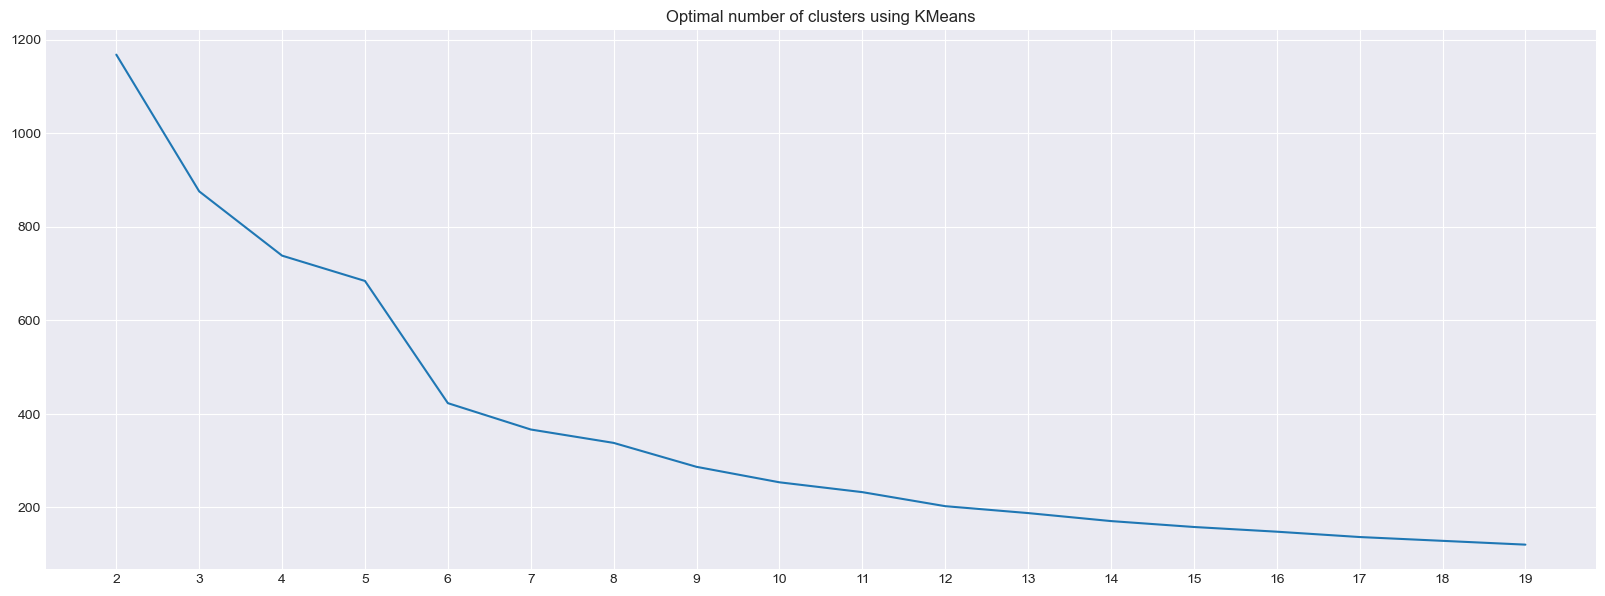

In [10]:
km_inertia = [] 
max_clust = 20 

for k in range(2,max_clust):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(data_scaled) 
    km_inertia.append(kmeans.inertia_) 

k_values = range(1, len(km_inertia)+1)
kneedle = KneeLocator(k_values, km_inertia, curve='convex', direction='decreasing')
knee_point = kneedle.elbow 
print(f"The optimal number of clusters is: {knee_point}") 

plt.figure(figsize=(20,7)) 
plt.plot(range(2,max_clust), km_inertia)
plt.title('Optimal number of clusters using KMeans') 
plt.xticks([i for i in range(2, max_clust)], rotation=0)
plt.grid(True) 

#### Calculating Silhouette Score

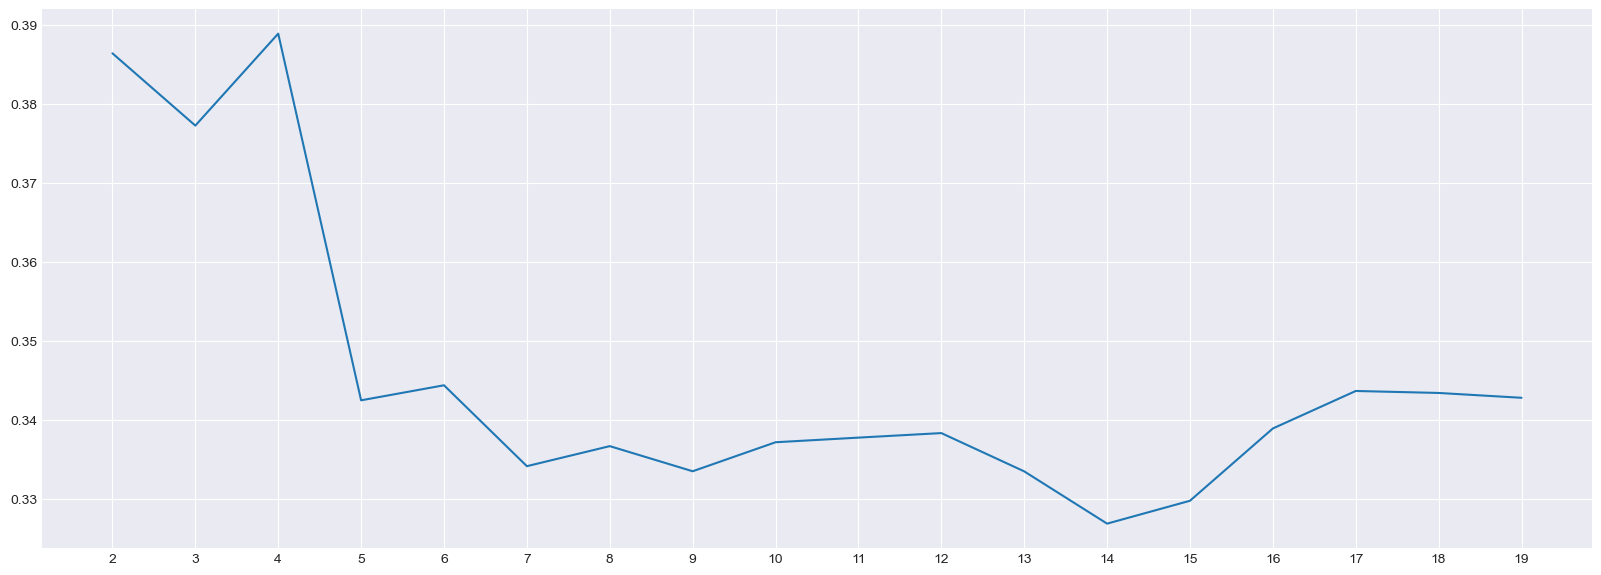

In [11]:
sil_score = [] 

for k in range(2, max_clust):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(data_scaled) 
    sil_score.append(silhouette_score(data_scaled, kmeans.labels_, random_state=42))

plt.figure(figsize=(20,7)) 
plt.plot(range(2,max_clust),sil_score)
plt.xticks([i for i in range(2, max_clust)], rotation=0)
plt.grid(True)  

#### Plotting clusters formed from KMeans

In [12]:
n_clust_km = knee_point 

k_means = cluster.KMeans(n_clusters=n_clust_km) 
k_means.fit(data_scaled) 

KMeans(n_clusters=5)

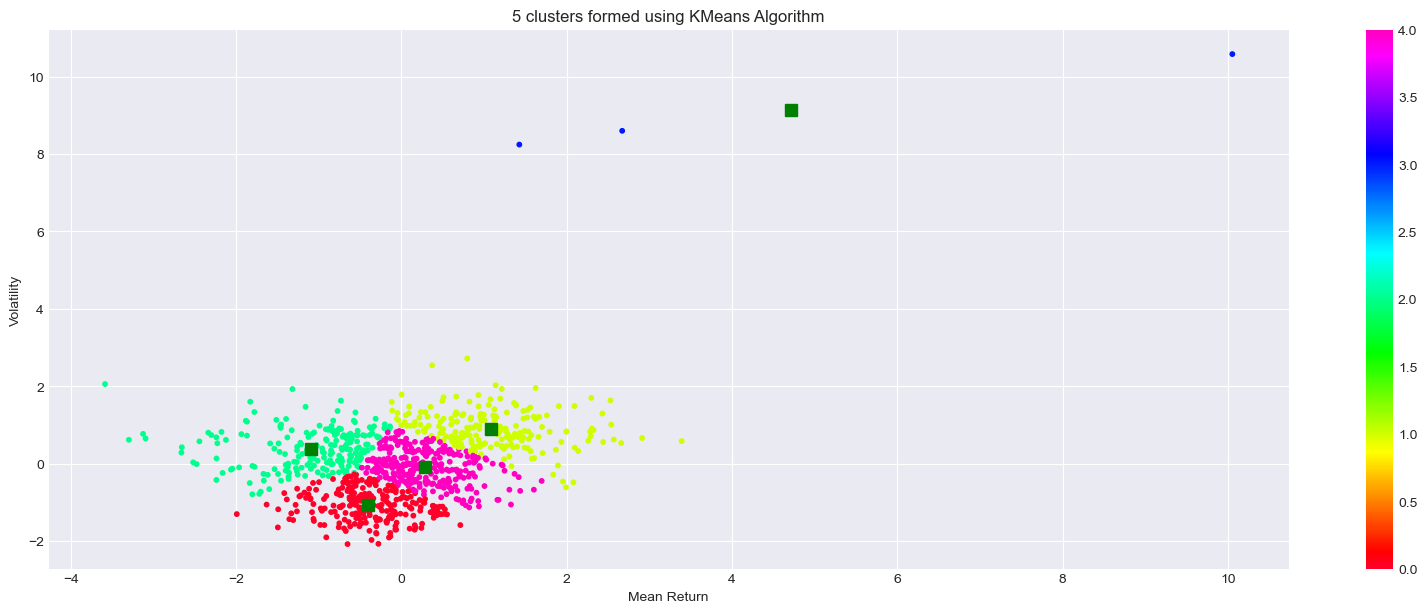

In [13]:
target_labels = k_means.predict(data_scaled) 

centroids = k_means.cluster_centers_
fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(111)
scatter = ax.scatter(data_scaled.iloc[:,0],data_scaled.iloc[:,1],c=k_means.labels_,
                     cmap='gist_rainbow', s=10, label=data_scaled.index)
ax.set_title(f'{n_clust_km} clusters formed using KMeans Algorithm') 
ax.set_xlabel('Mean Return') 
ax.set_ylabel('Volatility')  
plt.colorbar(scatter) 
plt.plot(centroids[:,0],centroids[:,1],'sg',markersize=8); 
plt.savefig('KMeans-cluster.png') 

#### Plotting the number of stocks in each cluster

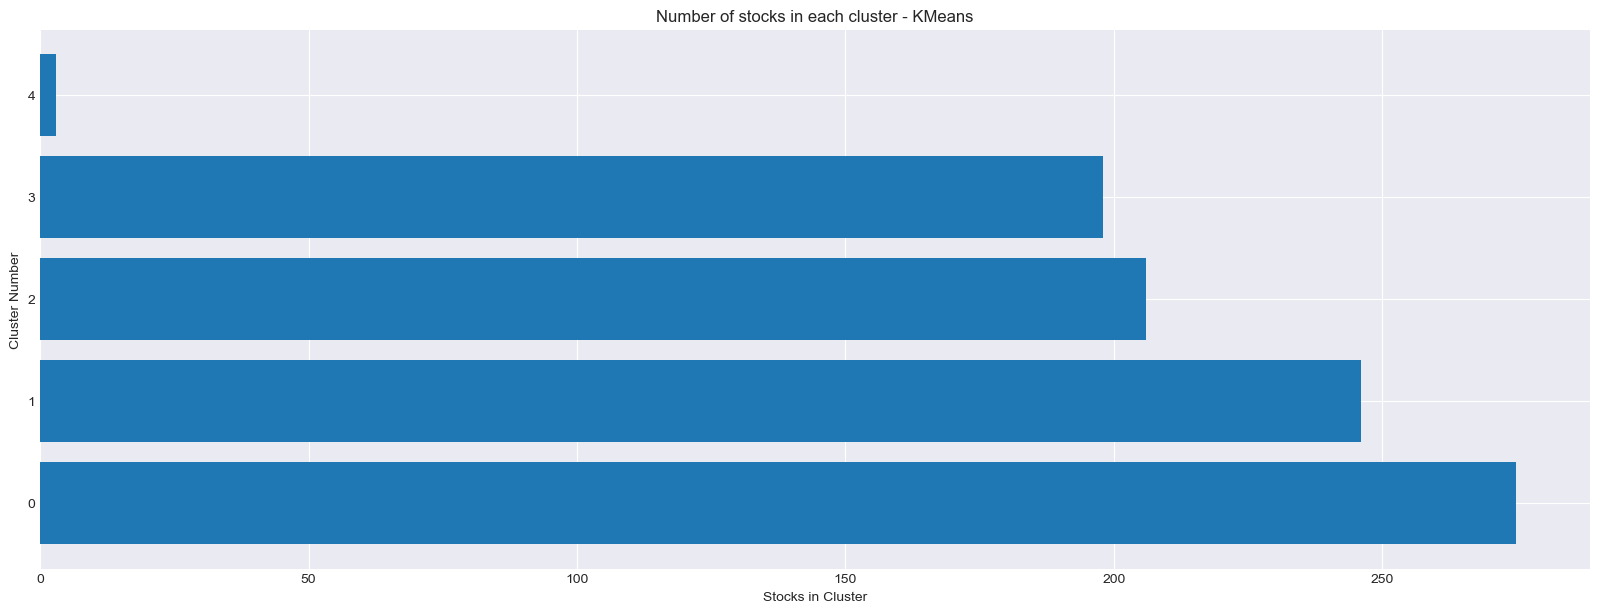

In [14]:
cluster_serieskm = pd.Series(index=data_scaled.index, data=k_means.labels_.flatten())
cluster_serieskm_all = pd.Series(index=data_scaled.index, data=k_means.labels_.flatten()) 
cluster_serieskm = cluster_serieskm[cluster_serieskm!=-1]

plt.figure(figsize=(20,7)) 
plt.barh(range(len(cluster_serieskm.value_counts())),
         cluster_serieskm.value_counts()) 
plt.title('Number of stocks in each cluster - KMeans') 
plt.xlabel('Stocks in Cluster') 
plt.ylabel('Cluster Number')  
plt.show()  

### 3.2 Agglomerative Clustering

#### Building Hierarchy Graph or Dendrogram

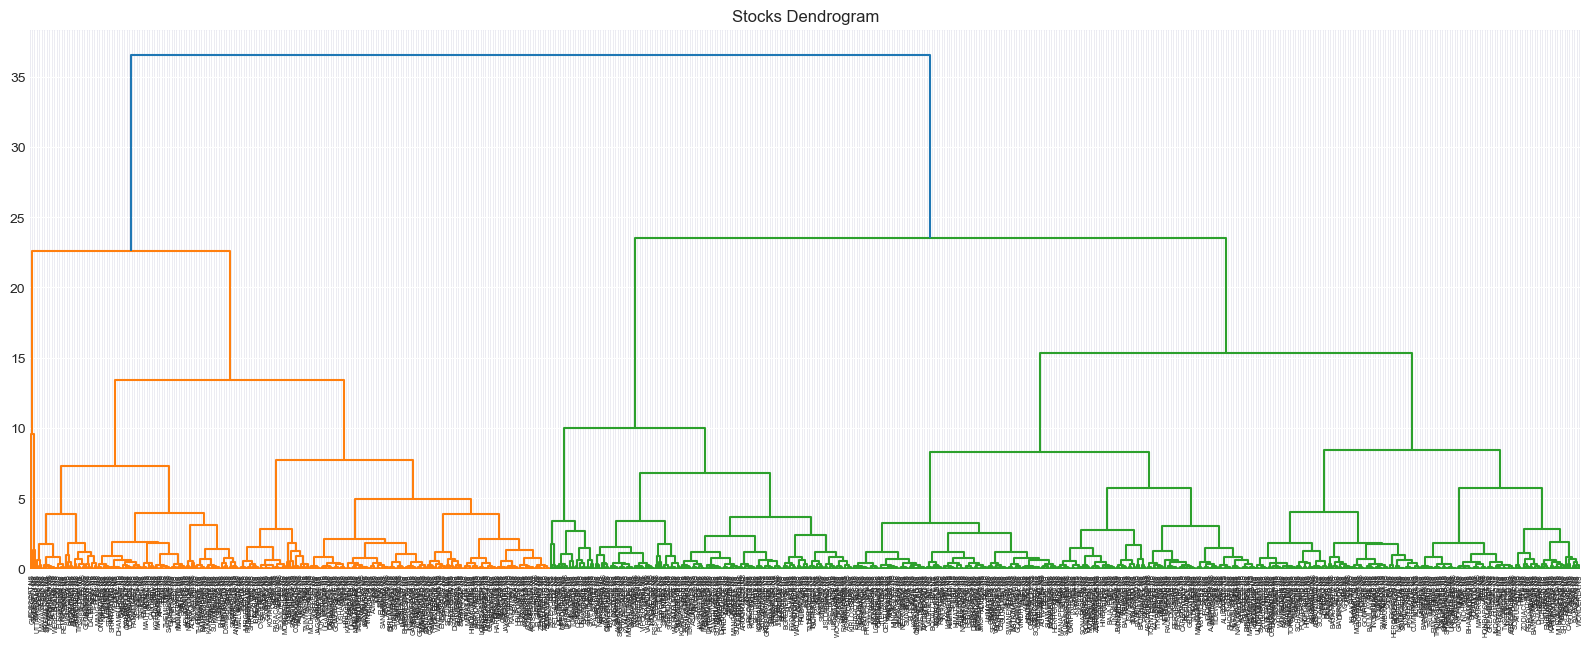

In [15]:
hrchy = linkage(data_scaled, method='ward') 
plt.figure(figsize=(20,7)) 
plt.title('Stocks Dendrogram') 
dendrogram(hrchy, labels=data_scaled.index) 
plt.show() 

#### Estimating Number of clusters formed

In [18]:
dist_threshold = 23
clusters = fcluster(hrchy, dist_threshold, criterion='distance')
df_clusters = pd.DataFrame(data=clusters, columns = ['cluster'])
print(f'Number of clusters formed : {len(df_clusters['cluster'].unique())}') 
print(df_clusters['cluster'].value_counts()) 

Number of clusters formed : 3
cluster
3    436
1    311
2    181
Name: count, dtype: int64


In [19]:
n_clust_agg = 3
aggl_clust = AgglomerativeClustering(n_clusters=n_clust_agg, linkage='ward')

clust_labels1 = aggl_clust.fit_predict(data_scaled) 

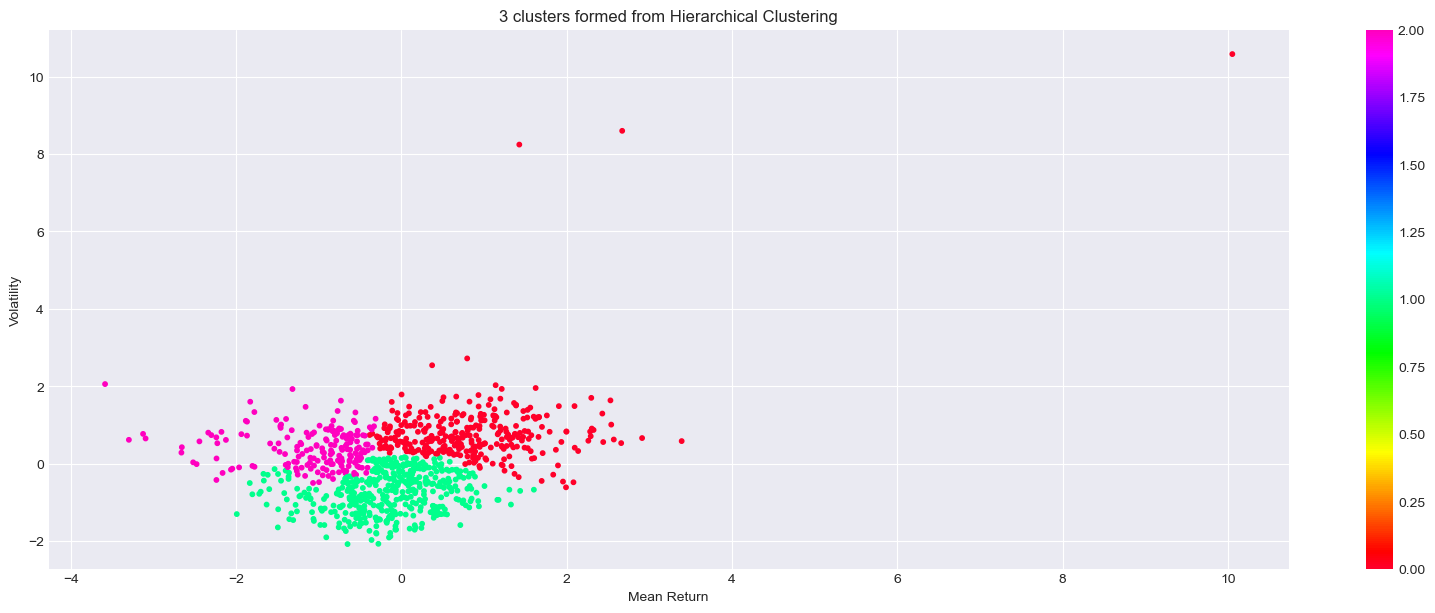

In [20]:
fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(111)
scatter = ax.scatter(data_scaled.iloc[:,0],data_scaled.iloc[:,1], s=10, c =clust_labels1, cmap ="gist_rainbow")
ax.set_title(f'{n_clust_agg} clusters formed from Hierarchical Clustering')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter); 
plt.savefig('Hierarchial-cluster.png') 

## 3.3 Affinity Propogation

In [21]:
ap = AffinityPropagation()
ap.fit(data_scaled) 

AffinityPropagation()

In [22]:
clust_labels2 = ap.predict(data_scaled)

cluster_indices = ap.cluster_centers_indices_
labels = ap.labels_

n_clusters_aff = len(cluster_indices) 
print('Estimated number of clusters : ',n_clusters_aff) 

Estimated number of clusters :  36


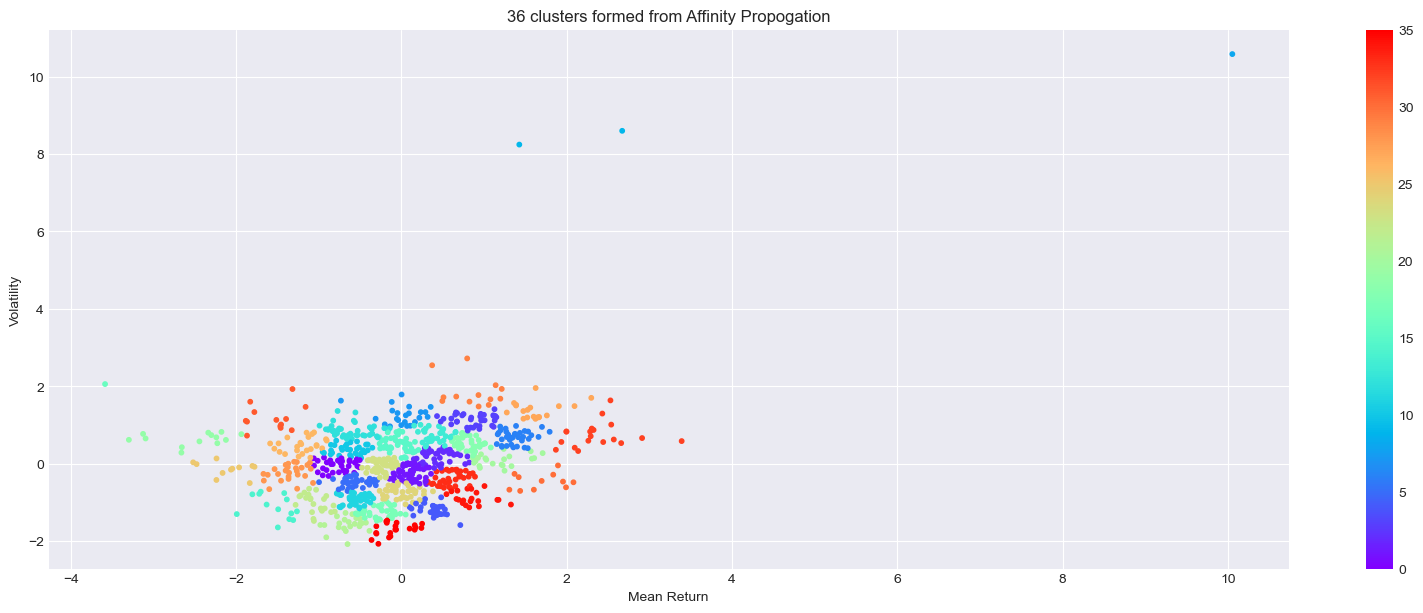

In [23]:
fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(111)
scatter = ax.scatter(data_scaled.iloc[:,0],data_scaled.iloc[:,1], c =clust_labels2, cmap ="rainbow", s=10)
ax.set_title(f'{n_clusters_aff} clusters formed from Affinity Propogation')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter); 
plt.savefig('affinity.png') 

#### Plotting centroids for clusters formed from Affinity Propogation

In [24]:
X_temp = np.asarray(data_scaled)
plt.close('all')
plt.figure(1)
plt.clf() 

fig = plt.figure(figsize=(20,7)) 
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_aff), colors):
    class_members = labels == k
    cluster_center = X_temp[cluster_indices[k]]
    plt.plot(X_temp[class_members, 0], X_temp[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=14)
    for x in X_temp[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)
plt.title('Plotting centroids for clusters formed from Affinity Propogation')
plt.show(); 

<Figure size 640x480 with 0 Axes>

#### Number of stocks in each cluster - Affinity Propogation

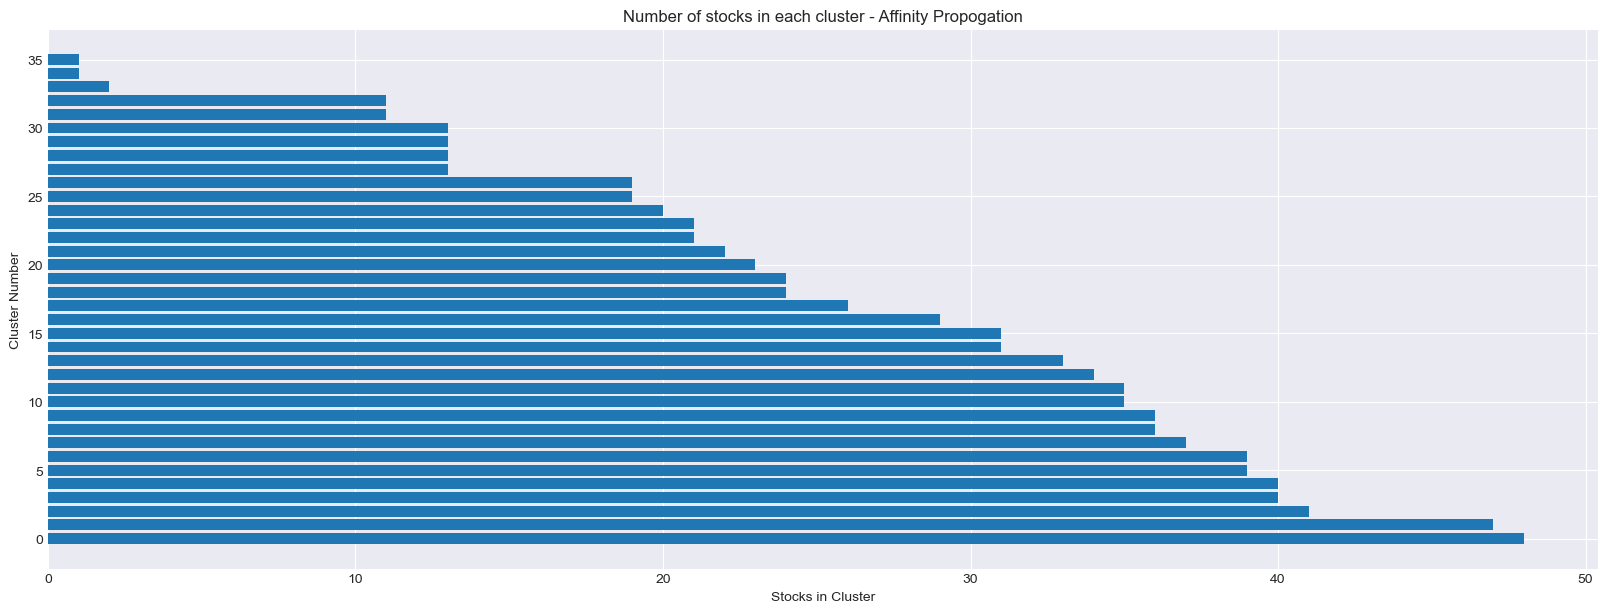

In [25]:
# show number of stocks in each cluster
clustered_series_ap = pd.Series(index=data_scaled.index, data=ap.labels_.flatten())
# clustered stock with its cluster label
clustered_series_all_ap = pd.Series(index=data_scaled.index, data=ap.labels_.flatten())
clustered_series_ap = clustered_series_ap[clustered_series_ap != -1]

plt.figure(figsize=(20,7))
plt.barh(
    range(len(clustered_series_ap.value_counts())), # cluster labels, y axis
    clustered_series_ap.value_counts()
)
plt.title('Number of stocks in each cluster - Affinity Propogation')
plt.xlabel('Stocks in Cluster')
plt.ylabel('Cluster Number')
plt.show(); 

## 3.4 DBSCAN Clustering

#### Calculating eps

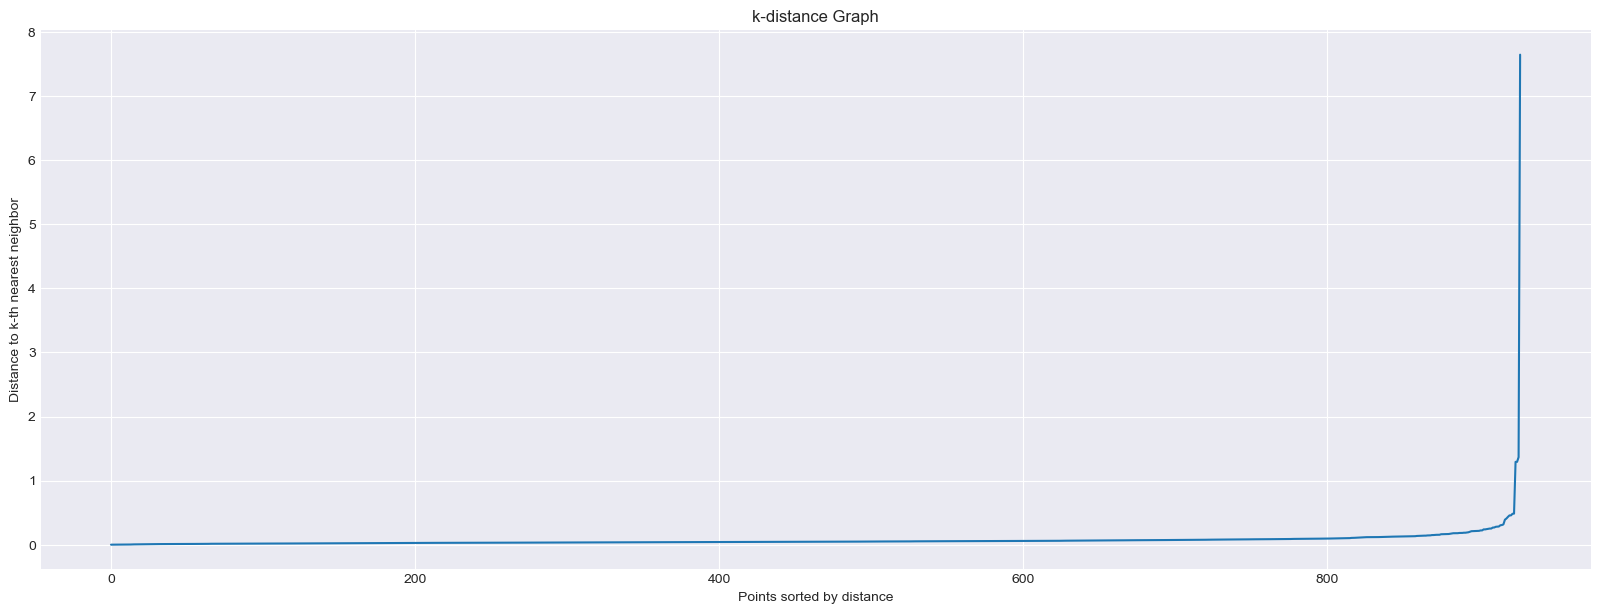

In [26]:
min_samples = 2
# Compute k-distances
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(data_scaled)
distances, indices = neighbors_fit.kneighbors(data_scaled)

# Sort distances
distances = np.sort(distances[:, min_samples-1], axis=0)

# Plot
plt.figure(figsize=(20,7)) 
plt.plot(distances)
plt.title('k-distance Graph')
plt.xlabel('Points sorted by distance')
plt.ylabel('Distance to k-th nearest neighbor')
plt.axis(True) 
plt.show();  

In [27]:
clf = DBSCAN(eps=0.2,min_samples=2)  
print(clf) 

clf.fit(data_scaled) 
labels = clf.labels_
n_cluster_db = len(set(labels)) - (1 if -1 in labels else 0) 
print('Clusters Discovered: %d' % n_cluster_db)  

DBSCAN(eps=0.2, min_samples=2)
Clusters Discovered: 19


In [28]:
clustereddb = clf.labels_ 
clustered_seriesdb = pd.Series(index=data_scaled.index, data=clustereddb.flatten()) 
clustered_seriesdb_all = pd.Series(index=data_scaled.index, data=clustereddb.flatten())
clustered_seriesdb = clustered_seriesdb[clustered_seriesdb!=-1]  

In [29]:
cluster_size_limit = 20
counts = clustered_seriesdb.value_counts() 
ticker_count_reduced = counts[(counts>1) & (counts<=cluster_size_limit)]
print(f'Clusters formed : {len(ticker_count_reduced)}')
print(f'Pairs to evaluate : {(ticker_count_reduced*(ticker_count_reduced-1)).sum()}') 

Clusters formed : 18
Pairs to evaluate : 184


### Visualization of Clusters formed - DBSCAN

In [30]:
x_tsne = TSNE(learning_rate=1000, perplexity=25, random_state=42).fit_transform(data_scaled) 

In [31]:
plt.figure(figsize=(20,7))
plt.clf()
plt.axis('off')

plt.scatter(x_tsne[(labels!=-1),0],x_tsne[(labels!=-1),1], s=50,alpha=0.85,c=labels[labels!=-1],
            cmap=cm.Paired)

plt.scatter(x_tsne[(clustered_seriesdb_all==-1).values,0], x_tsne[(clustered_seriesdb_all==-1).values,1],
            s=100, alpha=0.05) 

plt.title('T-SNE of all stocks with DBSCAN clusters'); 
plt.savefig('DBSCAN-cluster.png')

### Number of stocks in each cluster - DBSCAN

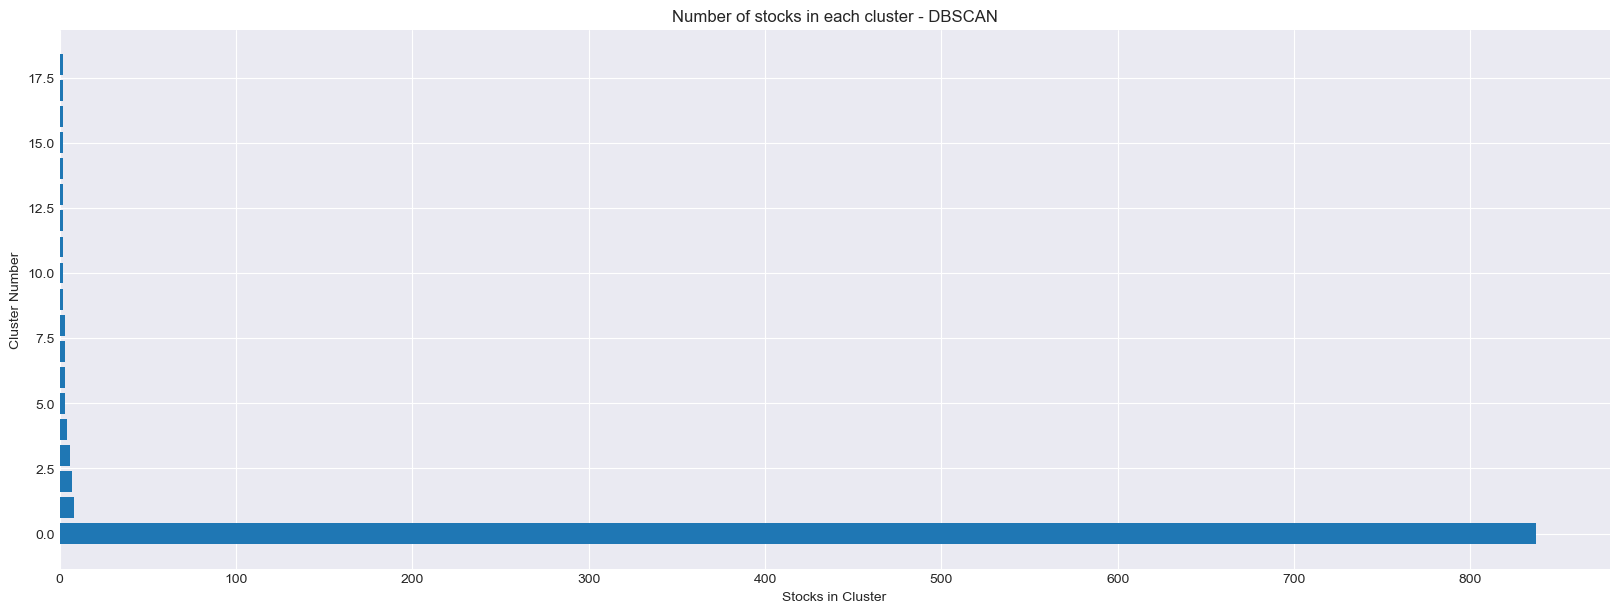

In [32]:
plt.figure(figsize=(20,7)) 
plt.barh(range(len(clustered_seriesdb.value_counts())),
         clustered_seriesdb.value_counts()) 
plt.title('Number of stocks in each cluster - DBSCAN') 
plt.xlabel('Stocks in Cluster') 
plt.ylabel('Cluster Number') 
plt.show(); 

## 4. Evaluating and Selecting Cluster Model

In [33]:
print('='*20,'Number of clusters formed in','='*20) 
print('KMeans : ',n_clust_km) 
print('Hierarchial : ',n_clust_agg) 
print('Affinity Propogation : ',n_clusters_aff) 
print('DBSCAN : ',n_cluster_db)  

==================== Number of clusters formed in ====================
KMeans :  5
Hierarchial :  3
Affinity Propogation :  36
DBSCAN :  19


Removing Noise from **clf.labels_**

In [34]:
labels = clf.labels_ 

if -1 in labels:
    mask = labels != -1 
    data_no_noise = data_scaled[mask] 
    labels_no_noise = labels[mask] 
else:
    data_no_noise = data_scaled
    labels_no_noise = labels 

In [35]:
print('='*20,'Silhouette scores for Algorithms','='*20) 
print('KMeans : ',silhouette_score(data_scaled, k_means.labels_, metric='euclidean')) 
print('Hierarchial : ',silhouette_score(data_scaled, aggl_clust.fit_predict(data_scaled), metric='euclidean')) 
print('Affinity Propogation : ',silhouette_score(data_scaled, ap.labels_, metric='euclidean')) 
print('DBSCAN : ',silhouette_score(data_no_noise, labels_no_noise, metric='euclidean'))  

==================== Silhouette scores for Algorithms ====================
KMeans :  0.34480819859741235
Hierarchial :  0.35640125825095226
Affinity Propogation :  0.3370779910180167
DBSCAN :  -0.22209758558304923


We select Affinity Propogation Model

In [36]:
def cluster_viz_count(cluster_series):
    counts = cluster_series.value_counts() 
    cluster_visualization_count = list(counts[(counts<=20) & (counts>1)].index)[::-1] 
    return cluster_visualization_count   

countskm = cluster_viz_count(cluster_serieskm)
countsdb = cluster_viz_count(clustered_seriesdb)
countsap = cluster_viz_count(clustered_series_ap) 

print(f'Num. of clusters with elements between 1 and 20 in KMeans : {len(countskm)}')
print(f'Num. of clusters with elements between 1 and 20 in Hierarchial : {1}') # Already discussed above
print(f'Num. of clusters with elements between 1 and 20 in DBSCAN : {len(countsdb)}')
print(f'Num. of clusters with elements between 1 and 20 in Affinity Propogation : {len(countsap)}')  

Num. of clusters with elements between 1 and 20 in KMeans : 1
Num. of clusters with elements between 1 and 20 in Hierarchial : 1
Num. of clusters with elements between 1 and 20 in DBSCAN : 18
Num. of clusters with elements between 1 and 20 in Affinity Propogation : 10


`Silhouette Scores` : Hierarchial Clusters have highest silhouette score among all the other cluster models. However, it doesn't create small clusters with elements between 1 and 20. So, it is not suitable for identifying specialized pairs which is the main aspect for pair-trading

`Small Clusters` : Although Affinity Propogation and DBSCAN create small clusters, we choose Affinity Propogation. Because it produces a substantial number of small clusters while maintaining a relatively good silhouette score.

### ==========The selected model is **Affinity Propogation**==========

## 5. Validating Cointegration relations and Selecting Pairs

In [37]:
def find_coint_pairs(dt, significance=0.05):
    n = dt.shape[1]
    score_matrix = np.zeros((n,n))
    pvalue_matrix = np.zeros((n,n))
    keys = dt.keys()
    pairs = [] 
    for i in range(n):
        for j in range(i+1,n):
            S1 = dt[keys[i]]
            S2 = dt[keys[j]]
            result = coint(S1,S2) 
            score = result[0]
            pvalue = result[1]
            score_matrix[i,j] = score 
            pvalue_matrix[i,j] = pvalue
            if pvalue<significance:
                pairs.append((keys[i],keys[j])) 
    return score_matrix, pvalue_matrix, pairs             

In [39]:
def plot_cluster_pairs_selected(clustered_series,counts,name):

    plt.figure(figsize=(20,7)) 

    for cluster in counts:    
        tickers = list(clustered_series[clustered_series==cluster].index)
        means = np.log(data_df[tickers]).mean() 
        dt = np.log(data_df[tickers]).sub(means) 
        dt.plot(title=f'Stock Time series for cluster {cluster} in {name}',figsize=(20,7))
        plt.xticks(rotation=0) 
        plt.show();  

    cluster_dict = {} 
    for i, clust in enumerate(ticker_count_reduced.index):
        tickers = clustered_series[clustered_series==clust].index
        score_matrix, pvalue_matrix, pairs = find_coint_pairs(data_df[tickers])
        cluster_dict[clust] = {} 
        cluster_dict[clust]['score_matrix'] = score_matrix 
        cluster_dict[clust]['pvalue_matrix'] = pvalue_matrix 
        cluster_dict[clust]['pairs'] = pairs 

    pairs = [] 
    for clust in cluster_dict.keys():
        pairs.extend(cluster_dict[clust]['pairs'])
    print(f"Total numbers of pairs passed cointegrated test are : {len(pairs)}")  

    stocks = np.unique(pairs)
    x_df = pd.DataFrame(index=data_scaled.index,data=data_scaled)
    pairs_series = clustered_series.loc[stocks]
    stocks = list(np.unique(pairs)) 
    x_pairs = x_df.loc[stocks] 

    x_tsne = TSNE(learning_rate=50,perplexity=3,random_state=42).fit_transform(x_pairs) 

    plt.figure(figsize=(20,7)) 
    plt.clf()
    plt.axis('off') 

    for pair in pairs:
        ticker1 = pair[0]
        loc1 = x_pairs.index.get_loc(pair[0]) 
        x1,y1 = x_tsne[loc1,:] 

        ticker2 = pair[0] 
        loc2 = x_pairs.index.get_loc(pair[1]) 
        x2,y2 = x_tsne[loc2,:] 

        plt.plot([x1,x2],[y1,y2],'k-',alpha=0.3,c='gray') 

    plt.scatter(x_tsne[:, 0], x_tsne[:, 1], s=220, alpha=0.9, c=pairs_series.values, cmap=cm.Paired)
    plt.title(f'T-SNE Visualization of Validated Pairs for {name} - {len(pairs)} passed cointegration pairs'); 
    plt.savefig('pairs-formed.png')
    return pairs 

<Figure size 2000x700 with 0 Axes>

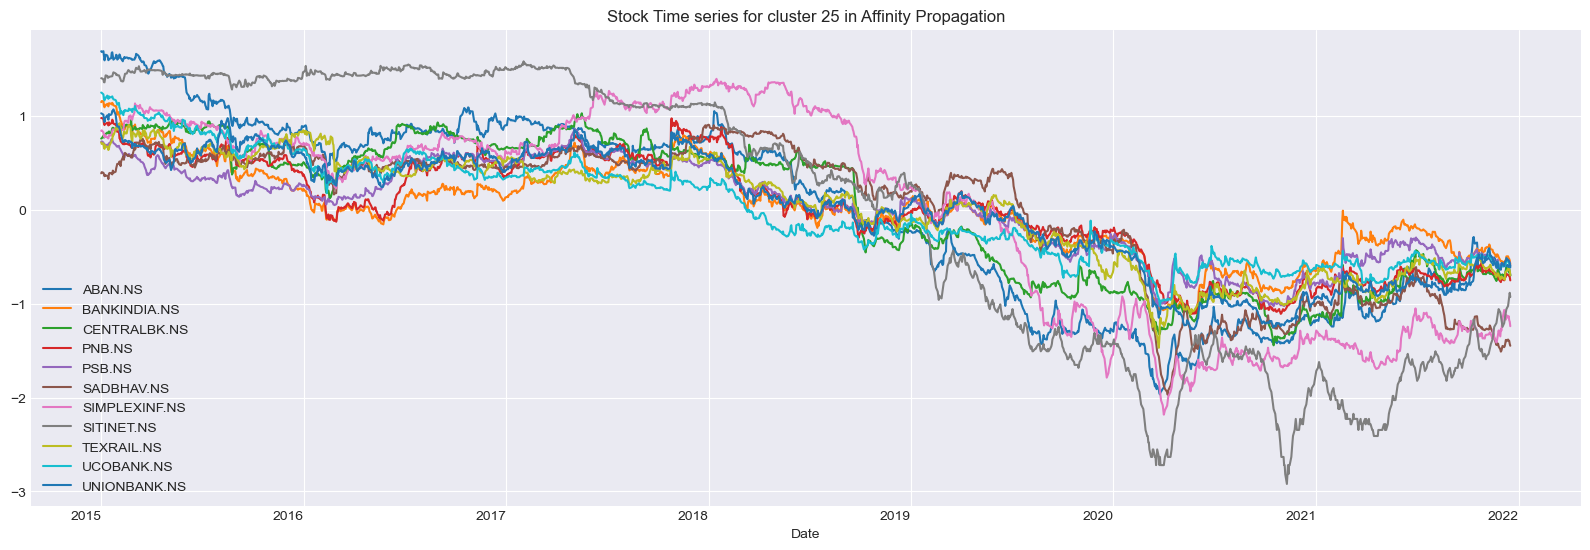

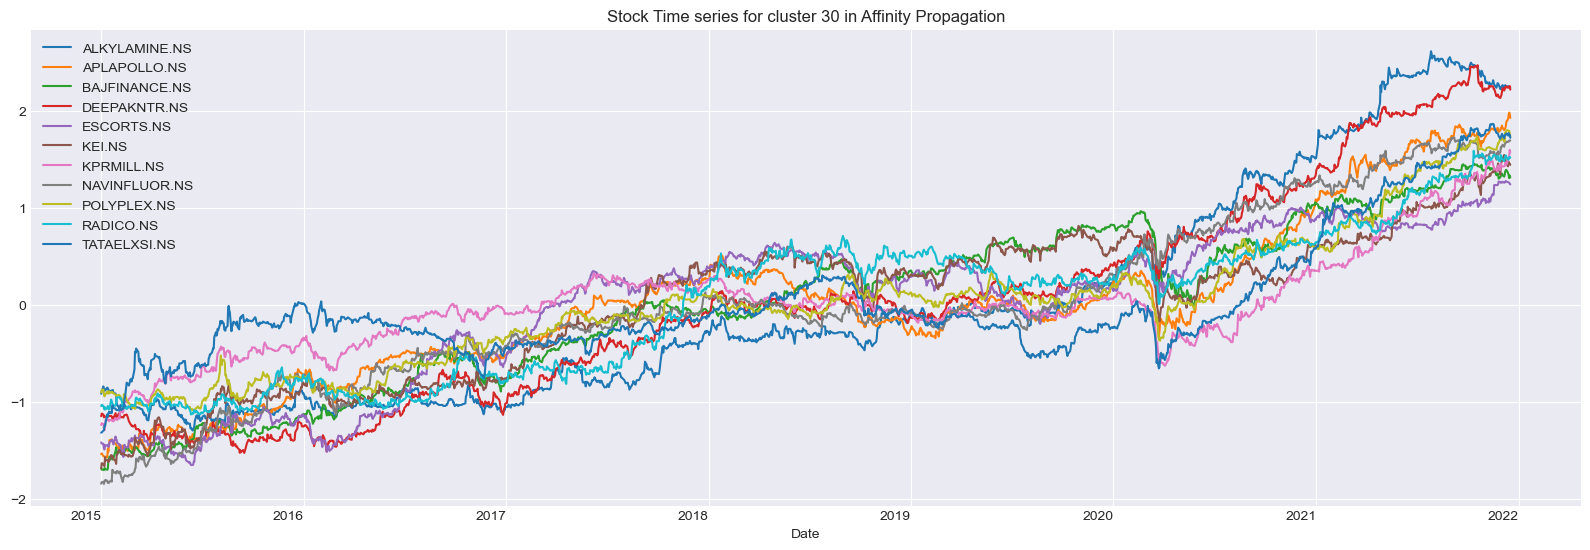

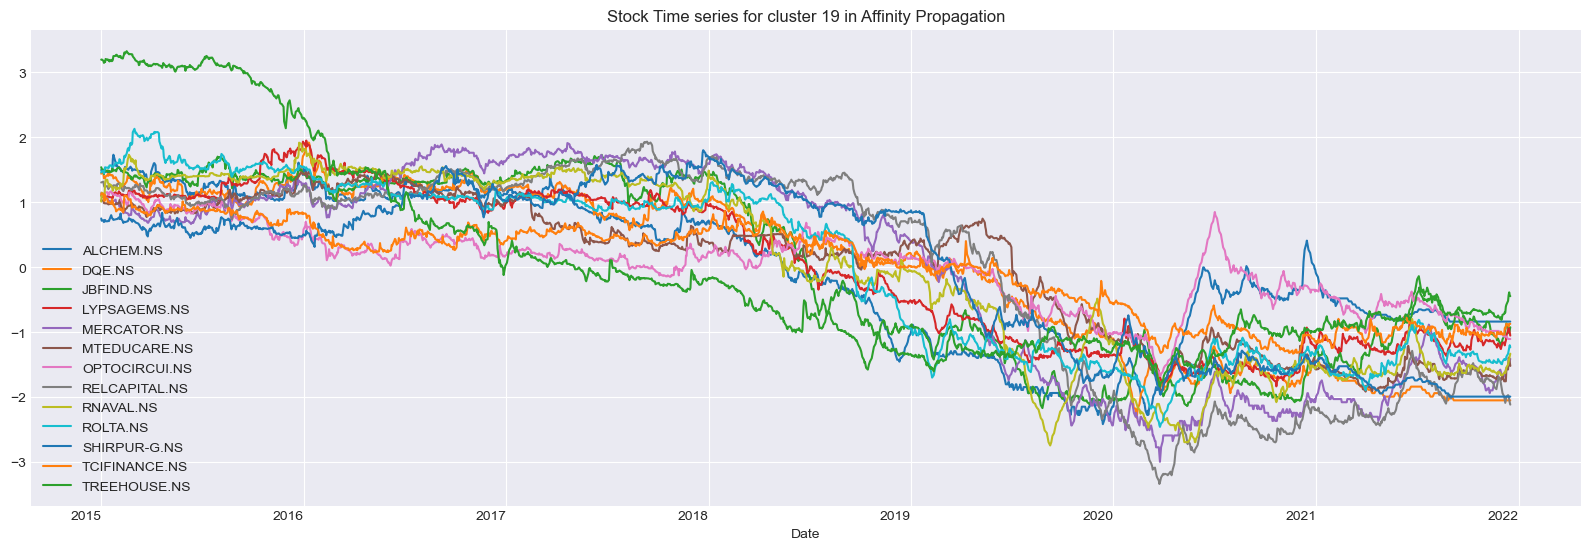

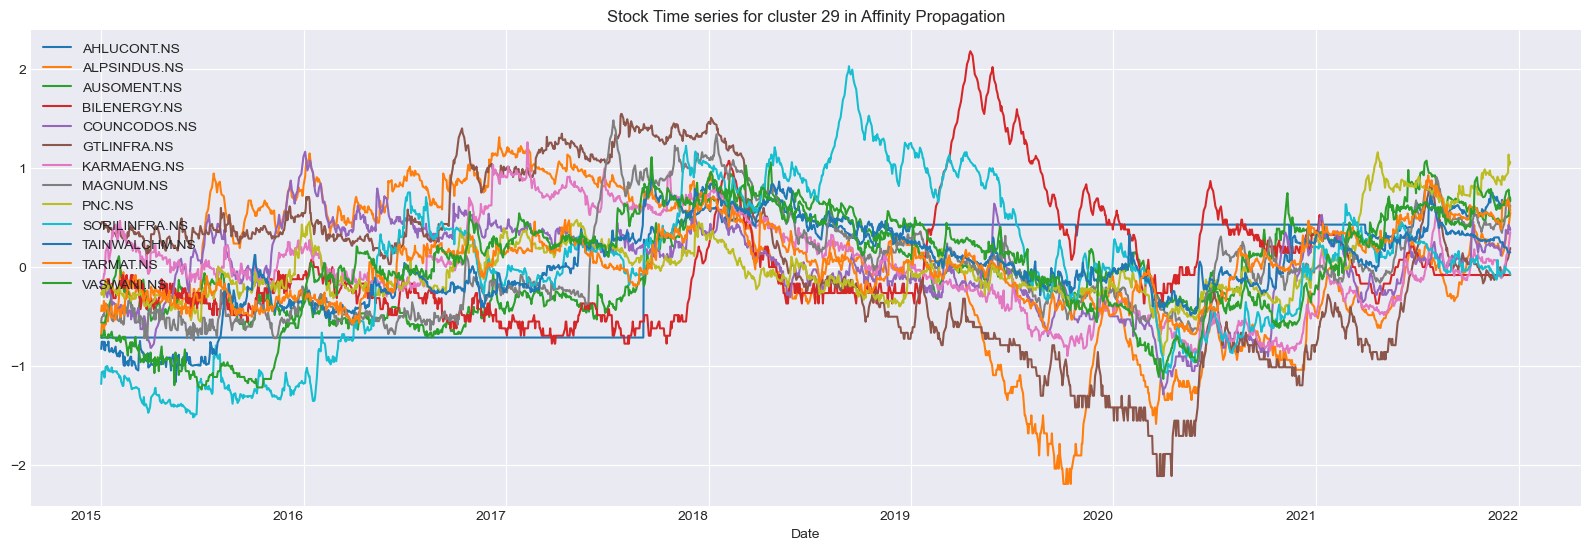

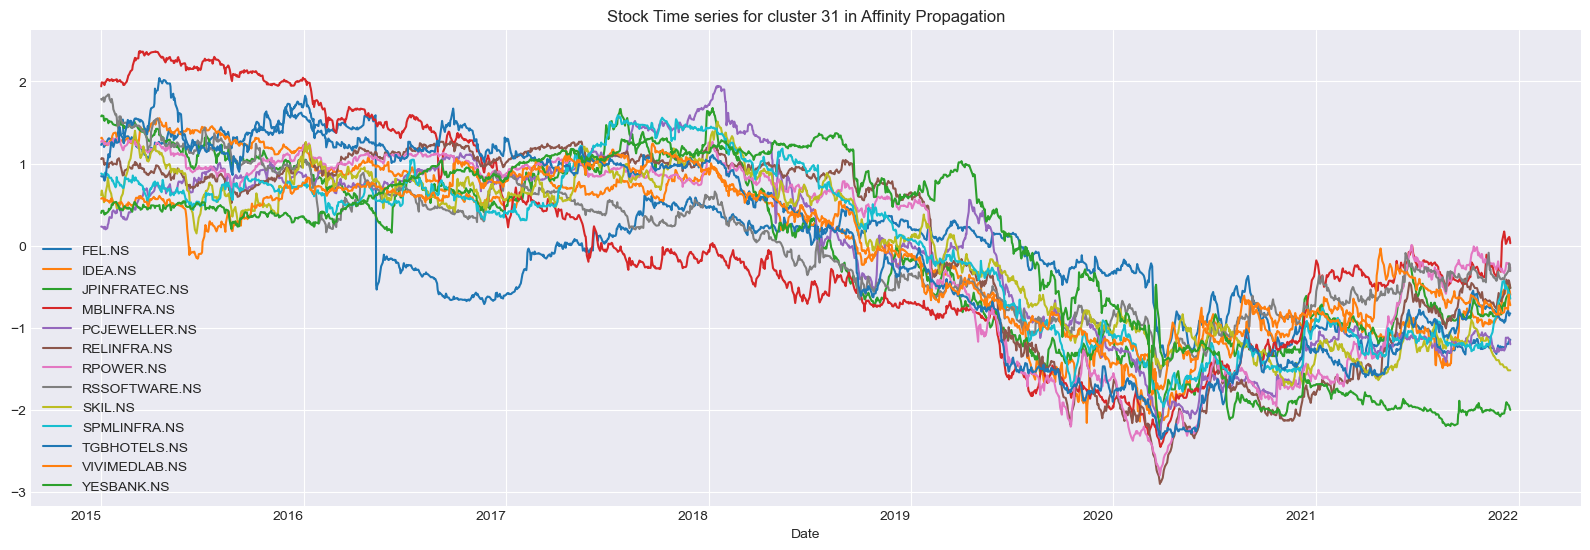

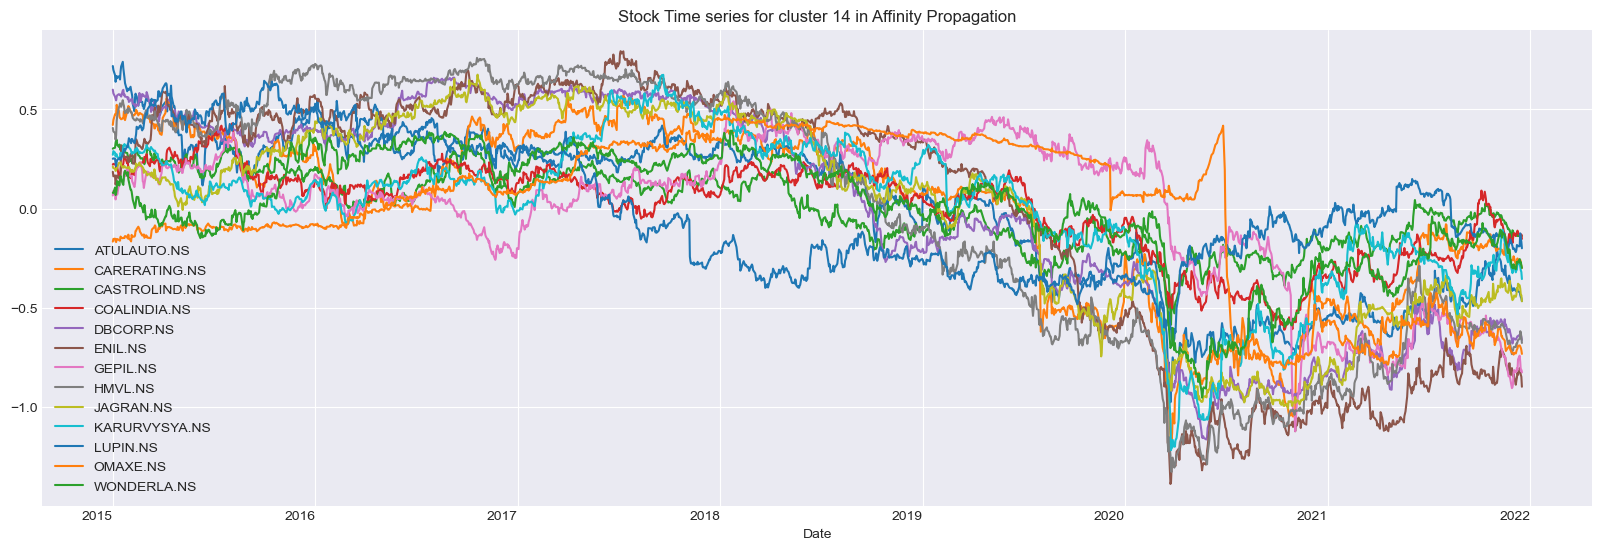

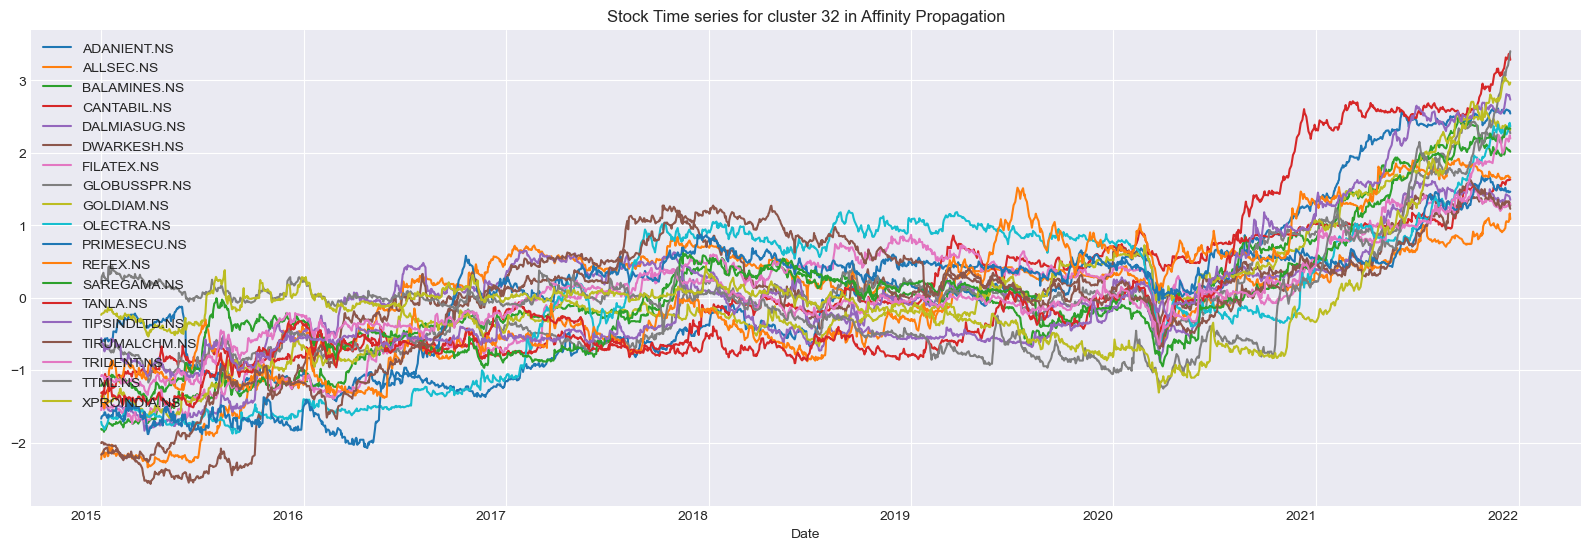

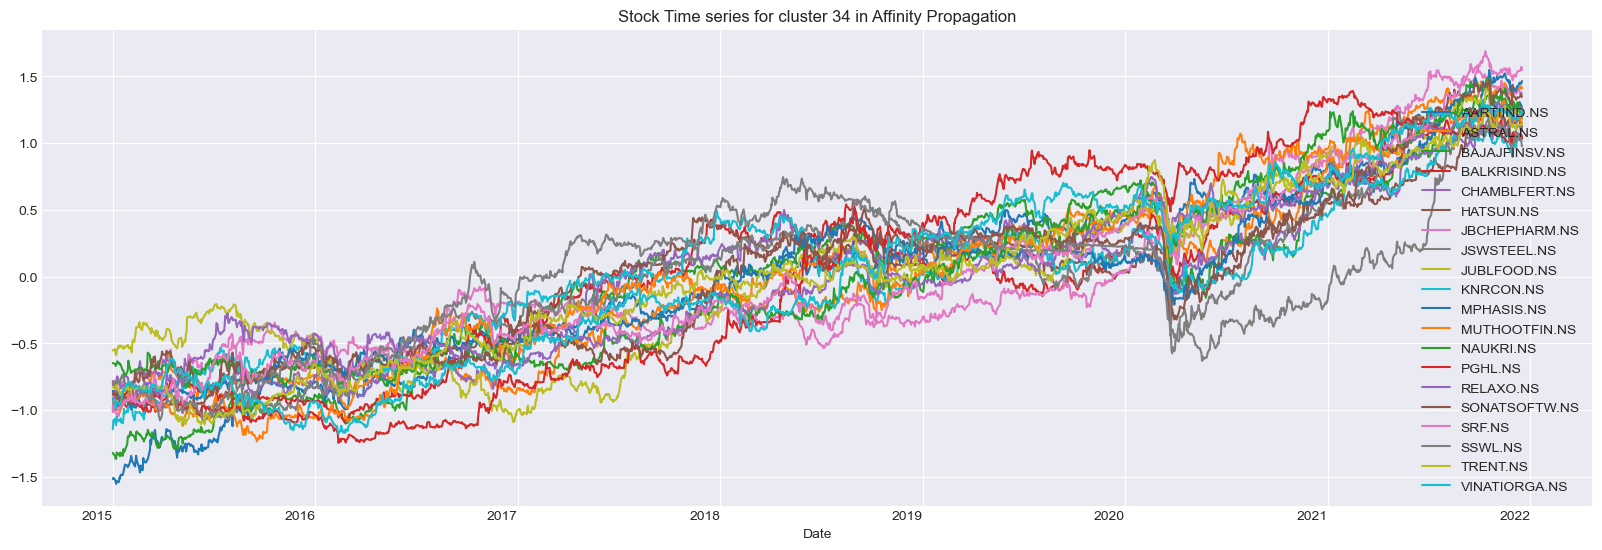

Total numbers of pairs passed cointegrated test are : 705


In [40]:
pairs = plot_cluster_pairs_selected(clustered_series_ap, countsap, 'Affinity Propagation')   

### 6. Random pair behaviour Visualization

P-value for ('NCLIND.NS', 'ORIENTBELL.NS') : 0.021039452644658015


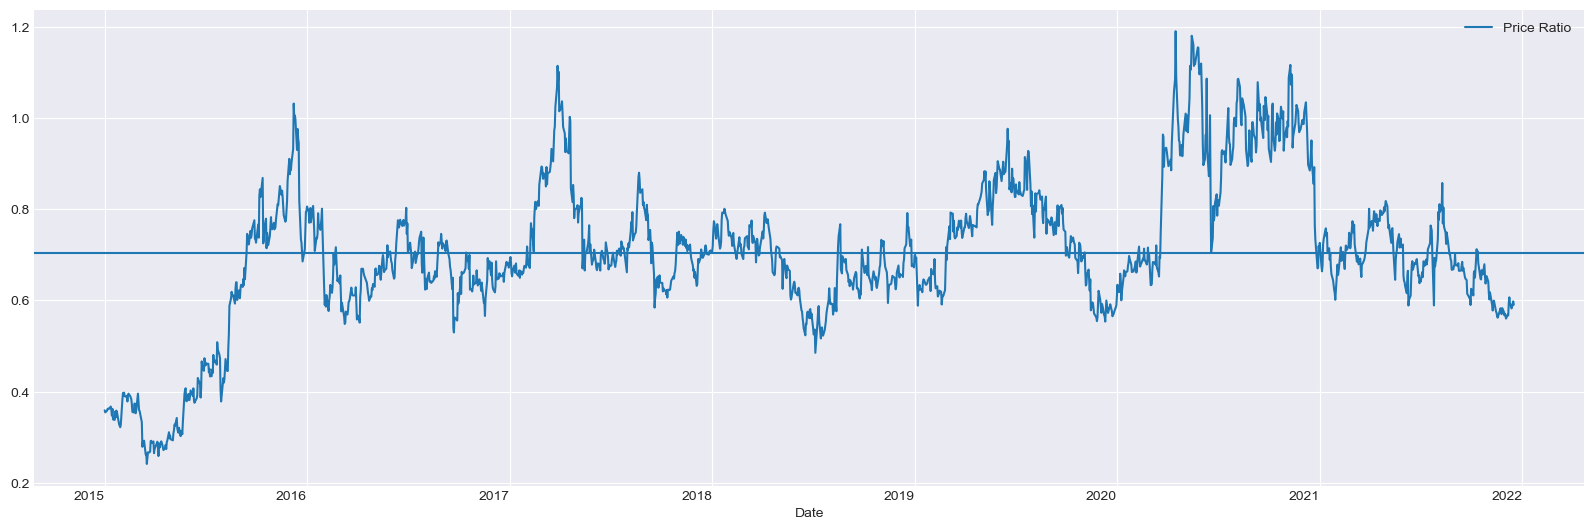

In [41]:
import random 
random.seed(20)
ran_pair = random.choice(pairs)

S1 = data_df[ran_pair[0]] 
S2 = data_df[ran_pair[1]] 

score,pvalue,_ = coint(S1,S2)
print(f'P-value for {ran_pair} : {pvalue}')
ratio = S1/S2 
ratio.plot(figsize=(20,7)) 
plt.xticks(rotation=0)
plt.axhline(ratio.mean())
plt.legend(['Price Ratio'])
plt.show() 

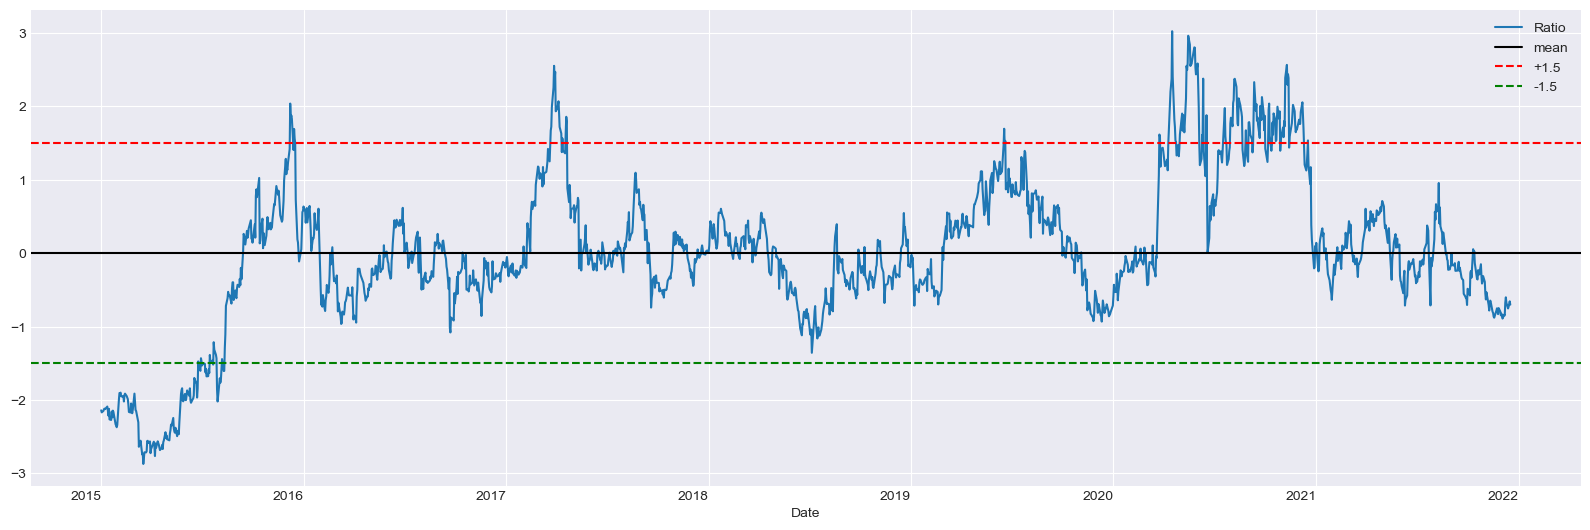

In [42]:
def zscore(series):
    Z = (series-series.mean())/np.std(series)
    return Z 

zscore(ratio).plot(figsize=(20,7))
plt.xticks(rotation=0)
plt.axhline(zscore(ratio).mean(), color='black') 
plt.axhline(1.5, color='red', linestyle='--')
plt.axhline(-1.5, color='green', linestyle='--')
plt.legend(['Ratio','mean','+1.5','-1.5'])
plt.show() 

### `Strategy` 

1. Go **Long** : whenever ratio **z-score < -1.5**
2. Go **Short** : whenever ratio **z-score > +1.5**   
3. **Exit** : when **z-score approaches 0**

Most often historical prices maynot be the representative of today. For this reason, we often use rolling windows of the most recent data

Instead of ratios, we use
1. 1d Moving Average : to compute z-score
2. 30d Moving Average : to compute mean
3. 30d Standard Deviation : to compute std deviation

In [43]:
ratios = S1/S2 
print(len(ratios))
train = ratios 

1718


In [44]:
ratios_MA1 = train.rolling(window=1, center=False).mean() 
ratios_MA30 = train.rolling(window=30, center=False).mean()

std_30 = train.rolling(window=30,center=False).std() 
std_30.name = 'std 30d'
zscore_30 = (ratios_MA1-ratios_MA30)/std_30
zscore_30.name = 'z-score' 

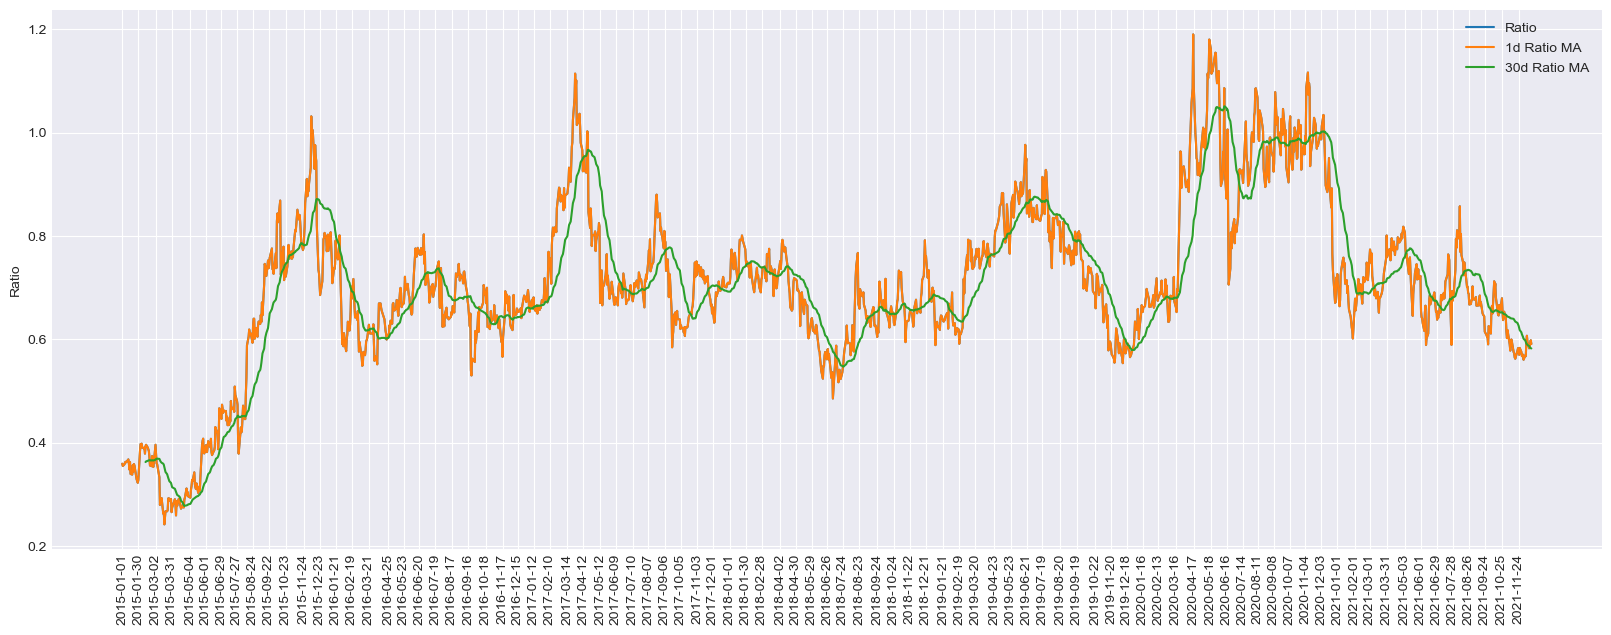

In [45]:
plt.figure(figsize=(20,7)) 
plt.plot(train.index, train.values)
plt.plot(ratios_MA1.index, ratios_MA1.values)
plt.plot(ratios_MA30.index, ratios_MA30.values)

plt.legend(['Ratio', '1d Ratio MA', '30d Ratio MA'])
plt.xticks(data_df.index[::20],rotation=90)
plt.ylabel('Ratio') 
plt.show()  

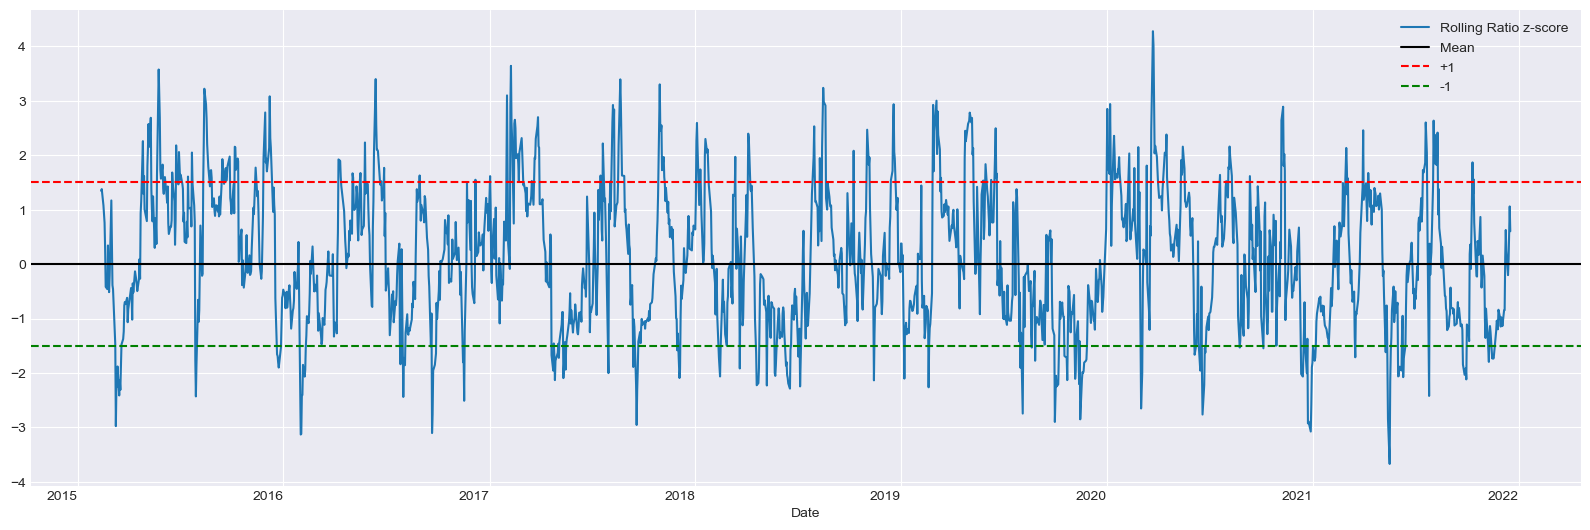

In [46]:
plt.figure(figsize=(20,7)) 
zscore_30.plot()
plt.axhline(0,color='black') 
plt.xticks(rotation=0)
plt.axhline(1.5, color='red', linestyle='--')
plt.axhline(-1.5, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-score', 'Mean', '+1', '-1'])
plt.show() 

### Plotting Buy and Sell Signal on z-score

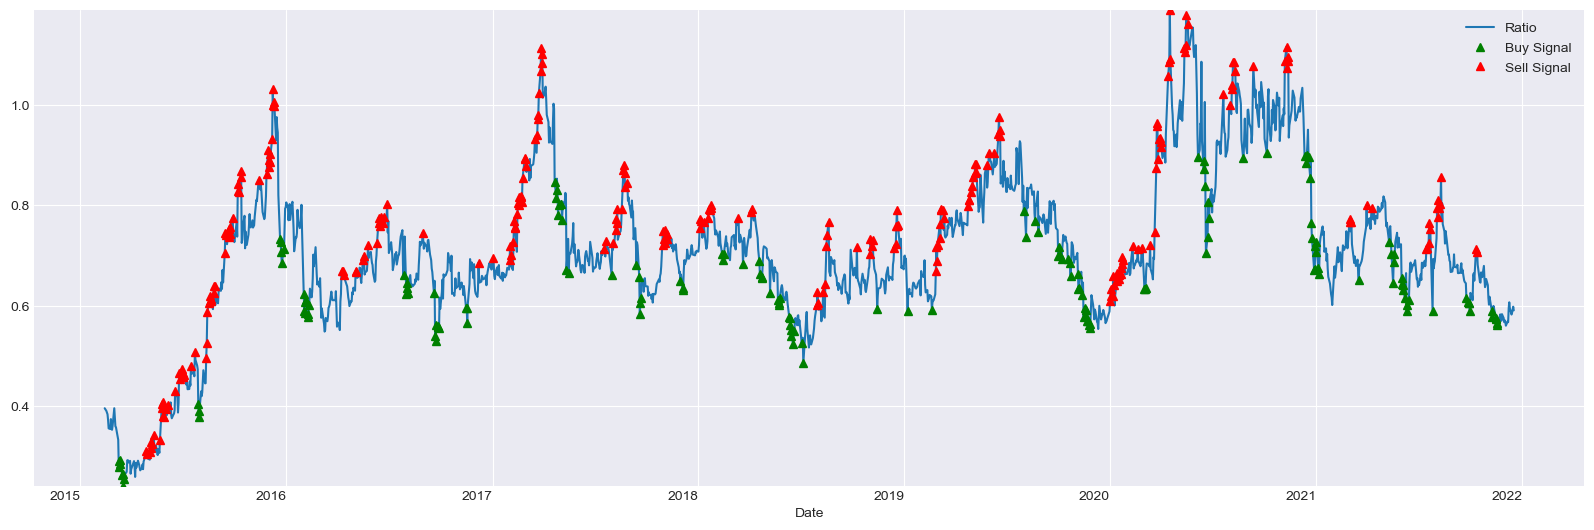

In [47]:
plt.figure(figsize=(20,7)) 
train[30:].plot()
buy = train.copy()
sell = train.copy() 

buy[zscore_30>-1.5] = 0     # zscore_30 less than or equal to -1.5 will be considered as buy signals 
sell[zscore_30<1.5] = 0     # zscore_30 greater than or equal to 1.5 will be considered as sell signals 

buy[30:].plot(color='g', linestyle='None', marker='^')
sell[30:].plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis() 
plt.xticks(rotation=0)
plt.axis((x1, x2, ratios.min(), ratios.max()))  
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.show() 

### Trading Algorithm

The trading is based on the z-score of the rolling mean of their price ratio

In [48]:
def trade(S1, S2, money, window1=1, window2=30):
    if window1==0 or window2==0: # If window length is 0, exit
        return 0
    
    ratios = S1/S2 
    ma1 = ratios.rolling(window=window1,center=False).mean() 
    ma2 = ratios.rolling(window=window2,center=False).mean() 
    std = ratios.rolling(window=window2,center=False).std() 

    zscore = (ma1-ma2)/std 

    # Simulate trading. Start with no money and no positions
    countS1, countS2, profit, c1, c2 = 0, 0, 0, 0, 0
    first_time = [0,0] 

    mon_list = pd.Series(index=data_df.index) 
    mon_list[mon_list.index==data_df.index[0]] = money 
    for i in range(len(ratios)):

        # Sell short if z-score>1.5
        if zscore[i]>1.5 and money>max(S1[i],S2[i]) and c1==0:
            countS1 -= int((money/2)/S1[i])
            countS2 += int((money/2)/S2[i])
            first_time = [S1[i],S2[i]]
            money -= -countS1*S1[i] + countS2*S2[i]
            c1 = 1 

        # Buy long if z-score<-1.5
        elif zscore[i]<-1.5 and money>max(S1[i],S2[i]) and c2==0:
            countS1 += int((money/2)/S1[i])
            countS2 -= int((money/2)/S2[i]) 
            first_time = [S1[i],S2[i]]     
            money -= countS1*S1[i]-countS2*S2[i]
            c2 = 1 

        # Clear positions if z-score between -0.1 and 0.1
        elif abs(zscore[i])<0.1:
            profit = countS1*(S1[i]-first_time[0])+countS2*(S2[i]-first_time[1]) 
            if(c1==1):
                money += -countS1*first_time[0] + countS2*first_time[1] + profit 
                c1 = 0
            if(c2==1):
                money += countS1*first_time[0] - countS2*first_time[1] + profit 
                c2 = 0 
            countS1 = 0
            countS2 = 0
            mon_list[mon_list.index==data_df.index[i]] = money      
    
    return mon_list           

In [49]:
nifty_50 = yf.download('^NSEI',start=start_date,end=end_date)['Adj Close']
nifty_50.head(3) 

[*********************100%%**********************]  1 of 1 completed


Date
2015-01-02    8395.450195
2015-01-05    8378.400391
2015-01-06    8127.350098
Name: Adj Close, dtype: float64

In [50]:
cum_returns_nifty = (nifty_50-nifty_50[0])*100/nifty_50
cum_returns_nifty.name = 'NIFTY-50'
cum_returns_nifty.tail(3) 

Date
2021-12-15    51.249898
2021-12-16    51.326210
2021-12-17    50.571965
Name: NIFTY-50, dtype: float64

In [51]:
benchmark = cum_returns_nifty[-1] 
print(f'benchmark is : {benchmark.round(0)}%')  

benchmark is : 51.0%


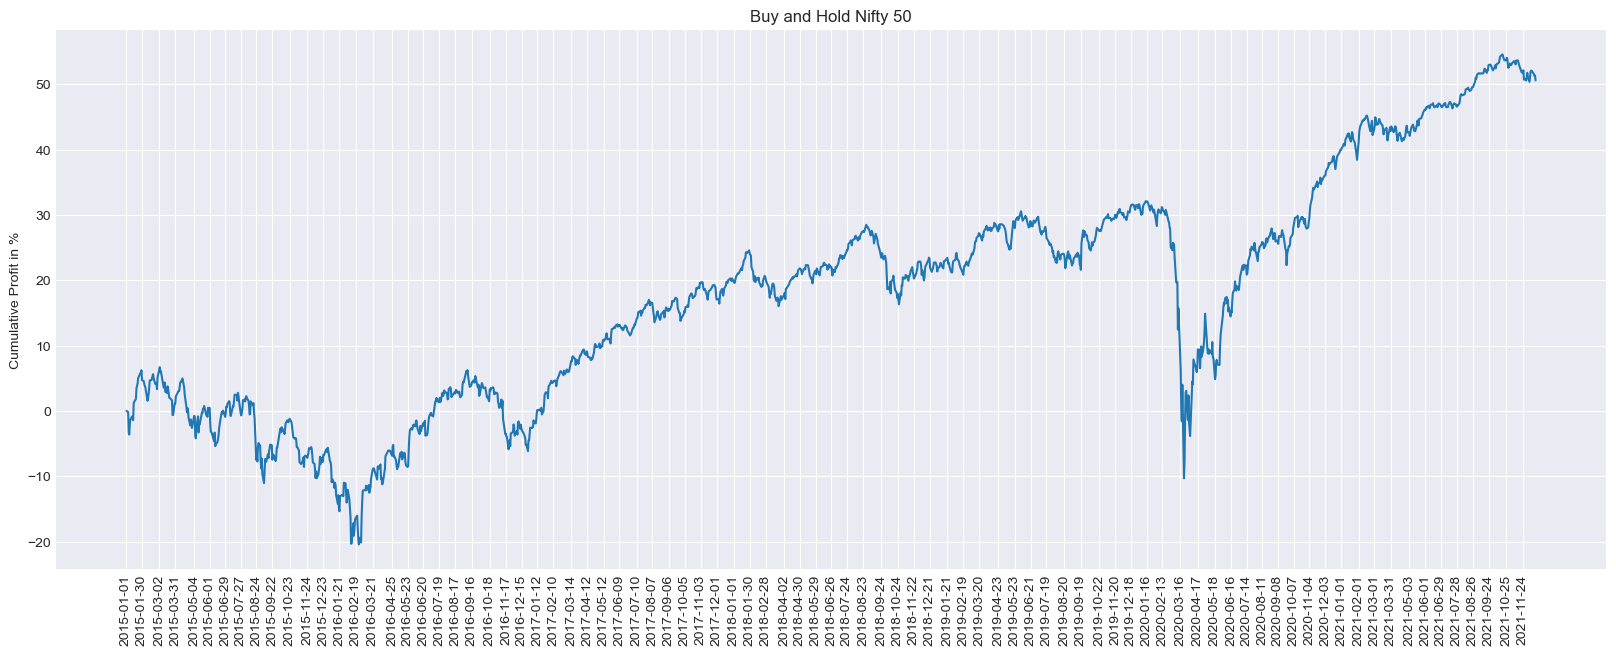

In [52]:
plt.figure(figsize=(20,7)) 
plt.plot(cum_returns_nifty) 
plt.xticks(data_df.index[::20],rotation=90)
plt.ylabel('Cumulative Profit in %') 
plt.title('Buy and Hold Nifty 50') 
plt.show()  

### 7. Trading all pairs listed by Affinity Propogation

In [53]:
final_output = pd.DataFrame(index=data_df.index)
final_pairs = []

for pr in pairs:
    S1 = data_df[pr[0]] 
    S2 = data_df[pr[1]]
    initial_money = 100000
    amt_list = trade(S1,S2,initial_money)
    amt_list.fillna(method='ffill',inplace=True)
    amt_list.name = pr[0]+'-'+pr[1]
    increment = (amt_list-initial_money)*100/initial_money
    if increment[-1]>benchmark:
        final_output = pd.concat([final_output,increment],axis=1)
        final_pairs.append(((increment[-1]),str(pr)))

final_pairs.sort(reverse=True) 

In [54]:
len(final_pairs)  

163

In [55]:
new_columns = final_output.columns[final_output.loc[final_output.last_valid_index()].argsort()]
final_output=final_output[new_columns]
final_output = pd.concat([final_output,cum_returns_nifty],axis=1,join='inner')
final_output.tail(1)   

ATULAUTO.NS-JAGRAN.NS  APTECHT.NS-GRAVITA.NS  \
Date                                                       
2021-12-17              51.032683               52.63124   

            CESC.NS-GANDHITUBE.NS  AUTOAXLES.NS-LUMAXTECH.NS  \
Date                                                           
2021-12-17              53.070647                   53.87363   

            FOSECOIND.NS-GAIL.NS  JKTYRE.NS-MANGLMCEM.NS  \
Date                                                       
2021-12-17             53.967738                55.71876   

            GREAVESCOT.NS-JYOTHYLAB.NS  ELECTCAST.NS-HINDMOTORS.NS  \
Date                                                                 
2021-12-17                   56.755556                   57.571263   

            ALKALI.NS-INDBANK.NS  COMPUSOFT.NS-SPIC.NS  ...  \
Date                                                    ...   
2021-12-17             59.331913              59.59326  ...   

            ASHOKLEY.NS-NATIONALUM.NS  SUNDARAM.NS-SUPERSPIN.NS  \
Date                                                              
2021-12-17                 473.281196                509.462711   

            CREST.NS-V2RETAIL.NS  INDORAMA.NS-JINDALPHOT.NS  \
Date                                                          
2021-12-17             571.93549                 576.583087   

            MADHAV.NS-NAHARINDUS.NS  BIRLAMONEY.NS-EMKAY.NS  \
Date                                                          
2021-12-17                590.31562              645.270561   

            AMDIND.NS-BAGFILMS.NS  ALPA.NS-MCDHOLDING.NS  \
Date                                                       
2021-12-17             708.739645             985.495912   

            ALKALI.NS-SALSTEEL.NS   NIFTY-50  
Date                                          
2021-12-17            1661.219621  50.571965  

[1 rows x 164 columns]

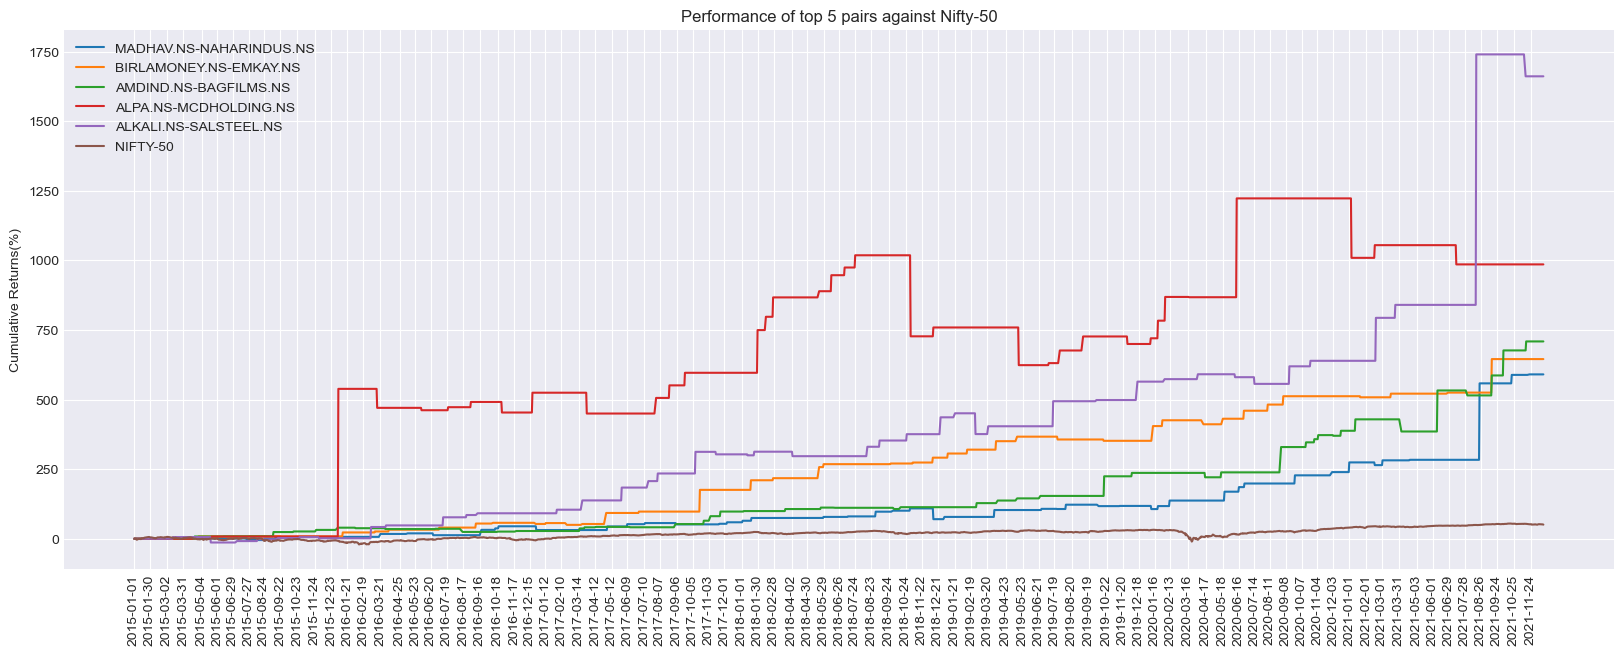

In [56]:
plt.figure(figsize=(20,7)) 
plt.plot(final_output.iloc[:,-6:],) 
plt.xticks(data_df.index[::20],rotation=90) 
plt.ylabel('Cumulative Returns(%)') 
plt.title('Performance of top 5 pairs against Nifty-50') 
plt.legend(final_output.columns[-6:]) 
plt.savefig('performance.png')
plt.show()  

In [57]:
print(f'Total pairs outperforming benchmark = {len(final_pairs)}')
final_output.iloc[-1,:] 

Total pairs outperforming benchmark = 163


ATULAUTO.NS-JAGRAN.NS          51.032683
APTECHT.NS-GRAVITA.NS          52.631240
CESC.NS-GANDHITUBE.NS          53.070647
AUTOAXLES.NS-LUMAXTECH.NS      53.873630
FOSECOIND.NS-GAIL.NS           53.967738
                                ...     
BIRLAMONEY.NS-EMKAY.NS        645.270561
AMDIND.NS-BAGFILMS.NS         708.739645
ALPA.NS-MCDHOLDING.NS         985.495912
ALKALI.NS-SALSTEEL.NS        1661.219621
NIFTY-50                       50.571965
Name: 2021-12-17 00:00:00, Length: 164, dtype: float64

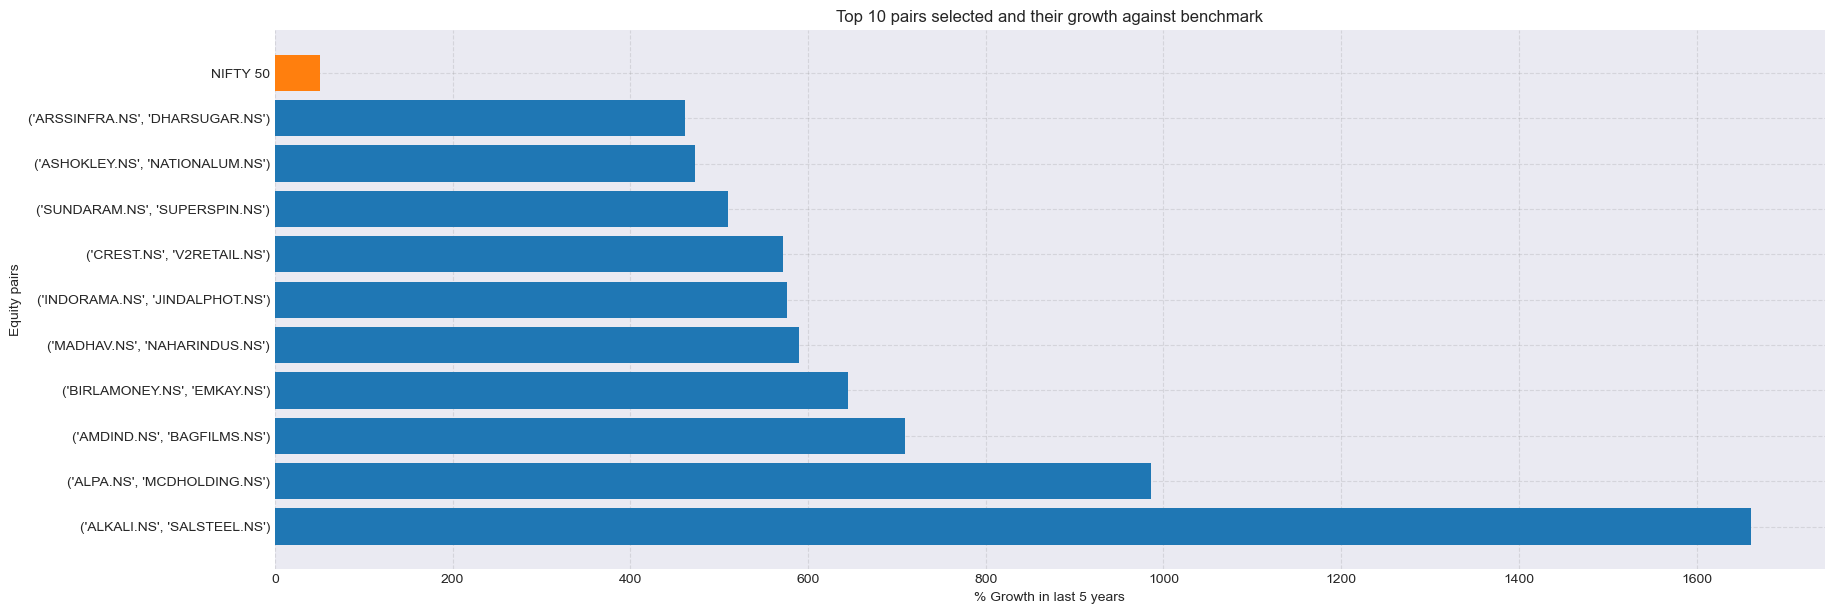

In [66]:
cum_profit = [] 
valuable_pairs = [] 
for l in final_pairs[:10]:
    cum_profit.append(l[0]) 
    valuable_pairs.append(l[1]) 
d_plot = pd.DataFrame(cum_profit,index=valuable_pairs)
fig,ax = plt.subplots(figsize=(20,7)) 
ax.grid(True,color='grey',linestyle='--',alpha=0.2)
ax.barh(d_plot.index,d_plot[0])    
ax.barh('NIFTY 50',benchmark)
ax.set_title('Top 10 pairs selected and their growth against benchmark')
plt.xlabel('% Growth in last 5 years') 
plt.ylabel('Equity pairs') 
plt.savefig('selected-pairs.png')
plt.show()     

### 8. Selecting stocks of top 10 pairs for portfolio

In [67]:
stocks_a = final_output.columns[-11:-1]  
stock_list = [col.split('-') for col in stocks_a]
flattened_columns = [item for sublist in stock_list for item in sublist]
flattened_columns 

['ARSSINFRA.NS',
 'DHARSUGAR.NS',
 'ASHOKLEY.NS',
 'NATIONALUM.NS',
 'SUNDARAM.NS',
 'SUPERSPIN.NS',
 'CREST.NS',
 'V2RETAIL.NS',
 'INDORAMA.NS',
 'JINDALPHOT.NS',
 'MADHAV.NS',
 'NAHARINDUS.NS',
 'BIRLAMONEY.NS',
 'EMKAY.NS',
 'AMDIND.NS',
 'BAGFILMS.NS',
 'ALPA.NS',
 'MCDHOLDING.NS',
 'ALKALI.NS',
 'SALSTEEL.NS']

In [68]:
len(flattened_columns) 

20

In [69]:
stocks_a 

Index(['ARSSINFRA.NS-DHARSUGAR.NS', 'ASHOKLEY.NS-NATIONALUM.NS',
       'SUNDARAM.NS-SUPERSPIN.NS', 'CREST.NS-V2RETAIL.NS',
       'INDORAMA.NS-JINDALPHOT.NS', 'MADHAV.NS-NAHARINDUS.NS',
       'BIRLAMONEY.NS-EMKAY.NS', 'AMDIND.NS-BAGFILMS.NS',
       'ALPA.NS-MCDHOLDING.NS', 'ALKALI.NS-SALSTEEL.NS'],
      dtype='object')